In [ ]:
import itertools
import random
import networkx as nx
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import pygraphviz as pgv
import time
import pickle
import os
import math
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D

<div>
    <h1> Trying to Re-create the Fractal Evolution of Gene Promoter Networks Using Aggregation </h1>
</div>
<br>
<h3> Computational Biology Final Project <h3>
By: Mohit Srivastav

<div class="alert alert-block alert-info">
    This project sought to re-create the paper, and expand upon the visualizations of, the paper by <a href="http://www.iaees.org/publications/journals/nb/articles/2011-1(2)/Diffusion-limited-aggregation-fractal-evolution-gene-promoter.pdf">Professor Aldritch</a> in Benedictine University. This project sought to combine my background in Physics in diffusion limited aggregation, alongside my background in computer algorithms to re-create the findings of this paper within this Jupyter Notebook.
</div>    

<div class="alert alert-block alert-info">
    <h1> These three functions do the following: </h1>
    <ol>
        <li> Produces a random string of base pairs using the bases "A", "T", "G", and "C" of a specified length </li>
        <li> Converts a floating point real number from a uniform distribution to an integer-values index </li>
        <li> Takes two strings and computes the number of base pairs shared in the same location between then </li>
    </ol>
</div>

In [ ]:
def produce_random_string_of_base_pairs(length):
    """
    Produces a random string of nucleotide base pairs of a specified length
    
    param length: the length of the string you want
    
    returns: A string of length "length" with randomized nucleotide bases
    
    """
    base_pairs = ["A","T","G","C"]
    random.seed()
    sequence = ""
    for i in range(length):
        sequence += np.random.choice(base_pairs)[0]
    return sequence

In [ ]:
def convert_to_index(n, distr):
    """
    Produces a random string of nucleotide base pairs of a specified length
    
    param n: The length of the iterable object you are trying to index
    
    param dist: The output of a uniformly distributed random number
    
    returns: An integer that is able to index the list whose size is given by n
    
    """
    distr = int(round(distr))
    if distr >= n:
        distr = n-1 #makes sure index is not greater than length
    return distr

In [ ]:
def bp_distance(n1, n2):
    """
    Produces a distance measurement based off of matching
    
    param n1: The first nucleotide sequence
    
    param n2: The second nucelotide sequence
    
    returns: A score of how many nucleotides match
    
    """
    tot = 0
    for i,j in zip(n1, n2):
        if i == j:
            tot += 1
    return tot

<div class="alert alert-block alert-info">
<h2> Now the string length is set to 11 (as specified in the study), and the "consensus" nucleotide sequence this network will be based off of </h2>

In [ ]:
F = 11
consensus = produce_random_string_of_base_pairs(F)

<div class="alert alert-block alert-info">
<h1> These arrays form the probability distributions of the generation </h1>
They come from the auxiliary tables from the study <br>
They are then normalized in the "generate_fitness_coefficients" function

In [ ]:
ATT_none = np.array([0, 1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
ATT_weak = np.array([0, 0.091, 0.182, 0.273, 0.364, 0.455, 0.545, 0.636, 0.727, 0.818, 0.909, 1.])
ATT_strong = np.array([0,0,0,0,0,0,0,0, 0.25, 0.5, 0.75, 1.])
ATT = np.vstack((ATT_none, ATT_weak, ATT_strong)).astype('float64')
print(ATT)

In [ ]:
REP_none = np.array([0,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
REP_weak = np.array([1,1,1,1,1,1,1,1,1,1,0.5,0])
REP_strong = np.array([1,1,1,1,1,1,1,1,0.5,0,0,0])
REP = np.vstack((REP_none, REP_weak, REP_strong)).astype('float64')
print(REP)

In [ ]:
Intrinsic = np.array([0.113935, 0.202643, 0.258547, 0.218363, 0.129674, 
                              0.054951, 0.017257, 0.003908, 0.000640, 0.000077, 0.000005, 0]).astype('float64')
print(Intrinsic)

In [ ]:
def generate_fitness_coefficients(ATT_val, REP_val): 
    """
    Takes in two numbers about the intensity of the repulsion or attraction and returns a probability distribution
        
    param ATT_val: The index for which row of the ATT matrix you want (0 -> no attraction, 1 -> weak attraction
                    2 -> strong attraction)
                    
    param REP_val: The index for which row of the REP matrix you want (0 -> no repulsion, 1 -> weak repulsion
                    2 -> strong repulsion)
    
    returns: An overall probability distribution that is normalized for proper GPN generation
    
    """
    if ATT_val > 2 or REP_val > 2:
        raise ValueError("values must be between 0 and 2 inclusive!")
        
    overall = Intrinsic*ATT[ATT_val]*REP[REP_val]
    overall *= (1./sum(overall))
    return overall

<div class="alert alert-block alert-info">
<h1> Promoters are then generated using the fitness coefficients. The function to make them, and distributions for all possible combinations of variables are depicted below</h1>

In [ ]:
def generate_promoter(Dup_rate, consensus, fitness_coefficients):
    """
    Generates a GPN using the various conditions
    
    param Dup_rate: The rate at which the consensus sequence is duplicated
        
    param consensus: The consensus nucleotide sequence which the GPN is centered on
                    
    param fitness_coefficients: The probability distribution generated by the "generate_fitness_coefficients" function
    
    returns: A new promoter that varies in some way, or is a duplicate of, the consensus sequence
    
    """
    prob = random.uniform(0,1)
    if prob <= Dup_rate:
        return consensus
    
    bp_sharing = 0
    while(bp_sharing == 0): #something always needs to be shared
        bp_sharing = np.random.choice(np.arange(F+1), p=fitness_coefficients) #select based off of the fitness coefficients

    changed = {} #dictionary for duplicate checking
    new_promoter = consensus
    
    for i in range(F - bp_sharing):
        index = np.random.choice(np.arange(0,F))
        while(changed.get(index) != None): #keep looping until something that was not found is found
            index = np.random.choice(np.arange(0,F))
        changed[index] = True
        new_promoter = new_promoter[:index] + np.random.choice(["A","T","G","C"])[0] + new_promoter[index + 1:]
    return new_promoter

In [ ]:
def histo_title_generator(ATT_val, REP_val):
    figtitle = ""
    
    if ATT_val == 0:
        figtitle += "ATT-NONE "
    elif ATT_val == 1:
        figtitle += "ATT-WEAK "
    else:
        figtitle += "ATT-STRONG "
    
    figtitle += " "*5
    
    if REP_val == 0:
        figtitle += "REP-NONE "
    elif REP_val == 1:
        figtitle += "REP-WEAK "
    else:
        figtitle += "REP-STRONG "
    
    return figtitle

In [ ]:
def run_visualization():
    """
    Generates 3000 promoters of each attribute style and plots it in a series of histograms
    
    return: the histograms for each parameter in its similarity to the consensus gene
    
    """
    histo_stuff = {}
    for dup_rate in (0,0.15,0.3):
        for att in range(3):
            for rep in range(3):
                for prom in range(3000):
                    promoter_generated = generate_promoter(dup_rate, consensus, generate_fitness_coefficients(att, rep))
                    if prom == 0:
                        histo_stuff[(dup_rate, att, rep)] = [bp_distance(promoter_generated, consensus)]
                    else:
                        histo_stuff[(dup_rate, att, rep)] += [bp_distance(promoter_generated, consensus)]

    fig, ax = plt.subplots(3,3, figsize=(3*10,3*7), sharey=True, sharex=True);
    plt.ylim(top=0.5);

    for i in sorted(histo_stuff.keys()):
        if i[2] == 0:
            if i[1] == 0:
                ax[0][0].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[0][0].legend(loc="upper left", prop={'size': 30});
                ax[0][0].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[0][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
            elif i[1] == 1:
                ax[0][1].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[0][1].legend(loc="upper left", prop={'size': 30});
                ax[0][1].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[0][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
            else:
                ax[0][2].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[0][2].legend(loc="upper left", prop={'size': 30});
                ax[0][2].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[0][2].tick_params(axis = 'both', which = 'major', labelsize = 30);

        elif i[2] == 1:
            if i[1] == 0:
                ax[1][0].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[1][0].legend(loc="upper left", prop={'size': 30});
                ax[1][0].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[1][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
            elif i[1] == 1:
                ax[1][1].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[1][1].legend(loc="upper left", prop={'size': 30});
                ax[1][1].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[1][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
            else:
                ax[1][2].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[1][2].legend(loc="upper left", prop={'size': 30});
                ax[1][2].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[1][2].tick_params(axis = 'both', which = 'major', labelsize = 30);

        elif i[2] == 2:
            if i[1] == 0:
                ax[2][0].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[2][0].legend(loc="upper left", prop={'size': 30});
                ax[2][0].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[2][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
            elif i[1] == 1:
                ax[2][1].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[2][1].legend(loc="upper left", prop={'size': 30});
                ax[2][1].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[2][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
            else:
                ax[2][2].hist(histo_stuff[i], histtype='step', label="DUP_RATE="+str(i[0]), range=(0,12), density=True, lw=5);
                ax[2][2].legend(loc="upper left", prop={'size': 30});
                ax[2][2].set_title(histo_title_generator(*i[1:]), fontsize='40')
                ax[2][2].tick_params(axis = 'both', which = 'major', labelsize = 30);

    fig.suptitle("Distribution of 3000 Generated Promoters' Similarity with the Consensus", fontsize='60', y=1);
    plt.tight_layout();
    plt.show();

<div class="alert alert-block alert-info">
<h1> The distributions of the bp matching scores for 3000 different randomly generated promoters with all possible combinations of values are depicted in the following slide </h1> </center>

In [ ]:
run_visualization()

<div class="alert alert-block alert-warning">

<h1> The fractal number of boxes required for a graph, in order to get its fractal dimension, is done using the <em> fractal_analysis</em> function, which uses the <em> box_creation </em> function repeatedly. </h1>
<h3> A single box is created as below, and then repeated until the entire network is covered by boxes
    <ol>
        <li>Construct the set C of all yet uncovered nodes</li>
        <li>Choose a random node <em>p</em> from C and remove it from C</li>
        <li>Remove from C all nodes whose distance from p is $\geq l_B$, since by definition they will not be in the same box </li>
        <li> Repeat steps 2 and 3 until C is empty </li>
    </ol>
</h3>

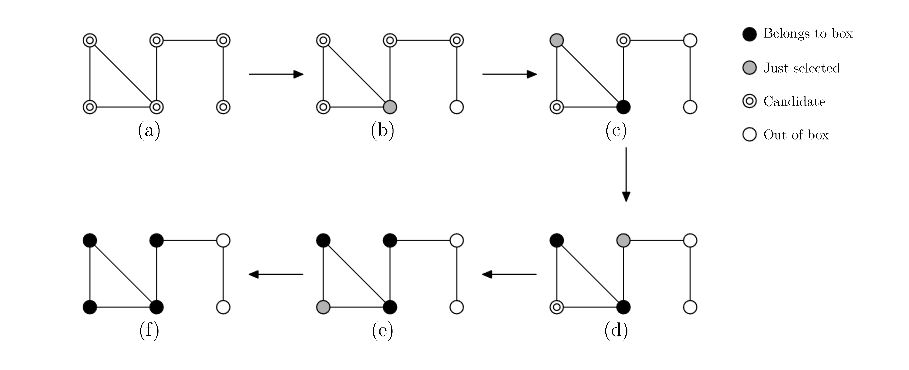

In [ ]:
def m_slice(m, G):
    """
    Takes in a graph and removes all edges with weight < m, and all isolated nodes afterwards
        
    param m: The value for which each edge will be compared to
                    
    param G: The graph being operated on
    
    returns: A new graph with all edge weights >= m and all isolated nodes removed
    
    """
    GPrime = G.copy()
    to_remove = []
    for edge in G.edges(data=True):
        if edge[2]['weight'] < m:
            to_remove.append((edge[0], edge[1]))
    GPrime.remove_edges_from(to_remove)
    GPrime.remove_nodes_from(list(nx.isolates(GPrime)))
    return GPrime

In [ ]:
def box_creation(uncovered, L_b, labels):
    """
    Takes in a set of currently uncovered nodes and 
    makes 1 box out of a randomly generated node
        
    param uncovered: The set of uncovered nodes
                    
    param L_b: the length value for which to compare
    
    param labels: the graph labels which dictate distance
    
    returns: a single box
    
    """
    total_nodes = uncovered.copy()
    chosen_nodes = set()
    while(len(total_nodes) != 0):
        p = np.random.choice(list(total_nodes))
        total_nodes.remove(p)
        chosen_nodes.add(p)
        
        to_remove = set()
        for node in total_nodes:
            if bp_distance(labels[node], labels[p]) >= L_b:
                to_remove.add(node)
        
        total_nodes -= to_remove
    
    return chosen_nodes #this is a single box

In [ ]:
def fractal_analysis(G, L_b, labels):
    """
    Takes in a set of currently uncovered nodes and 
    returns the number of boxes required for this graph and the given length
        
    param G: The graph
                    
    param L_b: the length value for which to compare
    
    param labels: the graph labels which dictate distance
    
    returns: The number of boxes required
    
    """
    graph_uncovered = set(G.nodes)
    
    color = 0
    while(len(graph_uncovered) > 0): #while you haven't covered the whole graph
        graph_uncovered -= box_creation(graph_uncovered, L_b, labels)
        color += 1
    
    return color #returns N_b

<div class="alert alert-block alert-warning">

<p>The secant method is a method for finding the zero of a given function given an interval $[a,b]$ where $f(a)*f(b) < 0$ and f(x) is continuous, or that there exists a point between a and b where the function intercepts the x axis. It is possible to use the secant method when determining $$\frac{N_B}{N} = l_B^{-d_B},$$ where $N_B$ is the number of "boxes" when coloring the graph using the <em>fractal_analysis</em> function, $N$ the total number of nodes, $l_B$ the edge length used for the boxes, and $d_B$ the fractal dimension.</p>
<br>
Since $N_B, N,$ and $l_B$ are known quantities, the function $f(d_B) = l_B^{-d_B} - \frac{N_B}{N} = 0$ can be solved for $d_B$ using the secant method. At $d_B=0, f(d_B)$ is guaranteed to be positive as $\frac{N_B}{N} \leq 1 \quad \forall \{N, N_B | N_B \leq N\}$. From this, the first negative value is scanned for in integer increments, and the first $d_B'$ where $f(d_B') < 0$ is taken as the second point in the interval. From this, the secant method can go on as normal.
<br>
The secant method is a way to approximate the zero of a function through the usage of secant lines. It is an iterative method where the next point, $p_{n+1}$, is determined by $p_n, p_{n-1}, f(p_n), \text{ and } f(p_{n-1})$. Namely,
$$p_{n+1} = p_n - f(p_n)\frac{p_n - p_{n-1}}{f(p_n) - f(p_{n-1})}$$

In [ ]:
def f(N_b, N, L_b, x):
    """
    The function f(d_B) from the above cell.
    
    param N_b: the number of boxes from the fractal_analysis function
    
    param N: the number of nodes in the graph being analyzed
    
    param L_b: the chemical length unit being used for the function
    
    param x: the d_B value that the function is varying
    
    return: the value of the function
    
    """
    return L_b**(-x) - (N_b/N)

def find_negative(f, N_b, N, L_b, starting_point):
    """
    The function finds the first negative value of a function beginning at a starting point
    
    param f: The function being used
    
    param N_b: the number of boxes from the fractal_analysis function
    
    param N: the number of nodes in the graph being analyzed
    
    param L_b: the chemical length unit being used for the function
    
    param starting_point: the point at which the function will start moving in a positive direction to scan from
    
    return: the first integer value found from the scan in the positive direction that is < 0
    
    """
    secant_next = starting_point
    nextVal = np.inf
    while nextVal >= 0:
        secant_next += 1
        nextVal = f(N_b, N, L_b, secant_next)
        
    return [secant_next]

def secant_method(f, N_b, N, L_b, valuesList):
    """
    A rootfinding method for a given function
    
    param f: The function being used
    
    param N_b: the number of boxes from the fractal_analysis function
    
    param N: the number of nodes in the graph being analyzed
    
    param L_b: the chemical length unit being used for the function
    
    param valuesList: a list of the values generated by the interval points a,b and the next points associated
    
    return: the value p_{n+1} which is closer to the root value
    
    """
    f_pn = f(N_b, N, L_b, valuesList[-1])
    f_pn_1 = f(N_b, N, L_b, valuesList[-2])
    return valuesList[-1] - f_pn*(valuesList[-1] - valuesList[-2])/(f_pn - f_pn_1)

In [ ]:
def fig_title_generator(DUP_RATE, ATT_val, REP_val, mult=False):
    """
    Generates the title for the figure
    
    param DUP_RATE: The duplication rate of the figure
    
    param ATT_val: the attraction index
    
    param REP_val: the repulsion index
    
    param mult: the number of edges relative to the number of nodes. A value of false means #E = #N^2
        
    return: a title for the figure given the specific attributes
    
    """
    figtitle = ""
    
    if mult == False:
        figtitle += "#E = #N^2 "
    else:
        figtitle += "#E = " + str(mult) + "*#N "
        
    figtitle += " "*5
    
    if ATT_val == 0:
        figtitle += "ATT-NONE "
    elif ATT_val == 1:
        figtitle += "ATT-WEAK "
    else:
        figtitle += "ATT-STRONG "
    
    figtitle += " "*5
    
    if REP_val == 0:
        figtitle += "REP-NONE "
    elif REP_val == 1:
        figtitle += "REP-WEAK "
    else:
        figtitle += "REP-STRONG "
        
    figtitle += " "*5
    
    figtitle += "DUP_RATE=" + str(DUP_RATE)
    
    return figtitle

In [ ]:
def workflow(iterations, DUP_RATE, ATT_val, REP_val, mult = False, dist_func=bp_distance):
    """
    The actual function for generating and analyzing the graph for the study
        
    param DUP_RATE: The duplication rate of the promoter generation
    
    param ATT_val: The attraction index of the promoter generation
    
    param REP_val: The repulsion index of the promoter generation
                    
    param mult: The number of edges generated relative to the number of nodes. False means there are N^2 edges for each node
    
    param dist_func: The distance function used to generate distances between nodes
    
    returns: A dictionary of dictionaries with each m slice and the fractal dimension of that slice
    
    """
    G = nx.Graph()
    labels = {}
    fractal_dim = {}
    overall_key = {}
    
    fig, ax = plt.subplots(1, F - 2, figsize = (10*(F-1), 10))
    
    fig.suptitle(fig_title_generator(DUP_RATE, ATT_val, REP_val, mult), fontsize='80')
    
    REF_PROB_LIST = generate_fitness_coefficients(ATT_val, REP_val)
    
    for i in range(iterations):
        promotion = generate_promoter(DUP_RATE, consensus, REF_PROB_LIST)
        labels[i] = promotion
        G.add_node(i)
        edges_to_add = []
        for j in range(i):
            edges_to_add.append((i,j, dist_func(labels[i], labels[j]))) #adds to the list of edges to add
            
        if mult:
            edges_to_add = sorted(edges_to_add, key=lambda tup: tup[2], reverse=True)
            edges_to_add = edges_to_add[:mult] #only adds the multiplier number of edges per node
            G.add_weighted_edges_from(edges_to_add)
        else:
            G.add_weighted_edges_from(edges_to_add)
            
    for m in range(2, F):
        G = m_slice(m, G) #takes the m slice of the graph
        try:
            ccs = G.subgraph(max(nx.connected_components(G), key=len)) #if there is no connected component throws an error
            pos = nx.nx_pydot.graphviz_layout(ccs) #lays out the new graph
            nx.draw_networkx(ccs, ax=ax[m - 2], pos=pos)
            ax[m - 2].set_title("m=" + str(m) + " with " + str(len(ccs.nodes)) + " nodes", fontsize='72')

            N_b = fractal_analysis(ccs, m, labels)
            N = len(ccs.nodes)
            valuesList = [0]
            valuesList += find_negative(f, N_b, N, m, 0)

            while abs(valuesList[-1] - valuesList[-2]) > 5e-6: #work down to a 10^-6 precision
                valuesList.append(secant_method(f, N_b, N, m, valuesList))

            fractal_dim[m] = valuesList[-1]
            
        except:
            nx.draw_networkx(nx.Graph(), ax=ax[m-2]) #plot an empty graph
            ax[m - 2].set_title("m=" + str(m), fontsize='72')
        
    fig.tight_layout()
    plt.show()
    overall_key[(DUP_RATE, ATT_val, REP_val, mult)] = fractal_dim
    return overall_key

In [ ]:
def workflowVisualization(iterations, DUP_RATE, ATT_val, REP_val, mult = False, dist_func=bp_distance):
    """
    A subset of the actual workflow function below to simply visualize the way that graphs are produced
        
    param DUO_RATE: The duplication rate of the promoter generation
    
    param ATT_val: The attraction index of the promoter generation
    
    param REP_val: The repulsion index of the promoter generation
                    
    param mult: The number of edges generated relative to the number of nodes. False means there are N^2 edges for each node
    
    param dist_func: The distance function used to generate distances between nodes
    
    returns: a set of subplots showing the way the graph has progressed
    
    """
    G = nx.Graph() #The graph being done
    labels = {} #The node labels
    
    val = int(math.sqrt(iterations))
    
    fig, ax = plt.subplots(val, val, figsize = (10*val, 10*val))
    
    fig.suptitle(fig_title_generator(DUP_RATE, ATT_val, REP_val, mult), fontsize=80, y=1)
    
    REF_PROB_LIST = generate_fitness_coefficients(ATT_val, REP_val)
    
    for i in range(iterations):
        promotion = generate_promoter(DUP_RATE, consensus, REF_PROB_LIST)
        labels[i] = promotion
        G.add_node(i)
        edges_to_add = []
        for j in range(i):
            edges_to_add.append((i,j, dist_func(labels[i], labels[j]))) #adds to the list of edges to add
            
        if mult:
            edges_to_add = sorted(edges_to_add, key=lambda tup: tup[2], reverse=True)
            edges_to_add = edges_to_add[:mult] #only adds the multiplier number of edges per node
            G.add_weighted_edges_from(edges_to_add)
        else:
            G.add_weighted_edges_from(edges_to_add)
        
        xindex = i//val
        yindex = i % val
        
        pos=nx.nx_pydot.graphviz_layout(G)
        if i > 0:
            edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
            
            nx.draw_networkx(G, pos=pos, font_size=50, ax=ax[xindex][yindex], 
                             node_size=4000,edgelist=edges, edge_color=weights, width=10.0, 
                             edge_cmap=plt.cm.plasma, font_color='whitesmoke')
            
            ax[xindex][yindex].set_title("iteration " + str(i), fontsize='60')
            
            labels2 = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels2, ax=ax[xindex][yindex], font_size='40')
        else:
            nx.draw_networkx(G, pos=pos, font_size=50, ax=ax[xindex][yindex], node_size=4000, font_color='whitesmoke')
            ax[xindex][yindex].set_title("iteration " + str(i), fontsize='60')
        
        
    plt.tight_layout();
    plt.show();

In [ ]:
workflowVisualization(9,0.1,0,0,mult=1);

In [ ]:
values = []
for dup_rate in (0,0.15,0.3):
    for att in range(3):
        for rep in range(3):
            for mult in (1,2,3): #generates a list of values for the function when multiprocessing
                values.append((dup_rate, att, rep, mult))

values = tuple(values)
print(values)

In [ ]:
def run(dup_rate, att, rep, mult):
    """
    Worker function for the multiprocessing of the workflow function
        
    param dup_rate: The duplication rate of the workflow function
    
    param att: The attraction index for the workflow function
    
    param rep: The repulsion index for the workflow function
                    
    param mult: The multiplicative edge value for the workflow function
    
    returns: The result of the workflow function (which is accumulated into a list by the multiprocessing below)
    
    """
    print(" ", end='') #required to show graphs for some reason
    return workflow(500, dup_rate, att, rep, mult)

In [ ]:
list_of_values = [] #keeps the list of values generated by the multiprocessing
start_time = time.time() #records the time taken just as a curiosity to see how long it takes
if __name__ == "__main__": #multiprocessing to save time on the actual computation
    with multiprocessing.Pool() as m:
        list_of_values = m.starmap(run, values) #this will return all of the dimensions into the list
print(time.time() - start_time)

In [ ]:
# with open('fractal_data.pkl', 'wb+') as file:
#     pickle.dump(list_of_values, file) #so that you do not have to re-run the file
# #MAKE SURE YOU DO NOT RUN THIS WHEN LOADING THE DATA AFTERWARDS, IT WILL WIPE THE DATA

In [ ]:
file = open('fractal_data.pkl', 'rb') #opens the saved data
list_of_values = pickle.load(file)
file.close()

In [ ]:
def line_title_generator(DUP, MULT):
    """
    A way to generate line titles for the legend
    
    param DUP: The duplication rate
    
    param MULT: The multiplication rate
    
    return: a title string based off of the fig title generator title
    
    """
    x = fig_title_generator(DUP,0,0,MULT).split()
    return x[0] + x[1] + x[2] + " " + x[-1]

In [ ]:
def visualize_fractal_dims(pltstyle):
    """
    A rootfinding method for a given function
    
    param pltstyle: The yscale style for the function (linear, log, logit, etc.)
    
    return: a visualization of the fractal dimension by the REP and ATT attributes
    
    """
    fig, ax = plt.subplots(3,3,figsize=(11*3,7*3), sharey=True, sharex=True)

    for i in list_of_values:
        for title, j in i.items():
            x = []
            y = []
            for key, value in j.items():
                x.append(key)
                y.append(value)

            if title[2] == 0:
                if title[1] == 0:
                    ax[0][0].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[0][0].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[0][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[0][0].set_yscale(pltstyle);
                    ax[0][0].set_ylabel('Fractal Dimension', fontsize='40');
                elif title[1] == 1:
                    ax[0][1].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[0][1].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[0][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[0][1].set_yscale(pltstyle);
                else:
                    ax[0][2].plot(x,y, label=line_title_generator(title[0], title[-1]));
                    ax[0][2].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[0][2].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[0][2].legend(bbox_to_anchor = (1.01,1.01), prop={'size': 20});
                    ax[0][2].set_yscale(pltstyle);

            elif title[2] == 1:
                if title[1] == 0:
                    ax[1][0].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[1][0].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[1][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[1][0].set_yscale(pltstyle);
                    ax[1][0].set_ylabel('Fractal Dimension', fontsize='40');
                elif title[1] == 1:
                    ax[1][1].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[1][1].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[1][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[1][1].set_yscale(pltstyle);
                else:
                    ax[1][2].plot(x,y, label=line_title_generator(title[0], title[-1]));
                    ax[1][2].legend(loc="upper left", prop={'size': 20});
                    ax[1][2].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[1][2].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[1][2].legend(bbox_to_anchor = (1.01,1.01), prop={'size': 20});
                    ax[1][2].set_yscale(pltstyle);

            elif title[2] == 2:
                if title[1] == 0:
                    ax[2][0].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[2][0].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[2][0].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[2][0].set_yscale(pltstyle);
                    ax[2][0].set_xlabel('m-slice value', fontsize='40');
                    ax[2][0].set_ylabel('Fractal Dimension', fontsize='40');
                elif title[1] == 1:
                    ax[2][1].plot(x,y)#, label=line_title_generator(title[0], title[-1]));
                    ax[2][1].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[2][1].tick_params(axis = 'both', which = 'major', labelsize = 30);
                    ax[2][1].set_yscale(pltstyle);
                    ax[2][1].set_xlabel('m-slice value', fontsize='40');
                else:
                    ax[2][2].plot(x,y, label=line_title_generator(title[0], title[-1]));
                    ax[2][2].legend(loc="upper left", prop={'size': 20});
                    ax[2][2].set_title(histo_title_generator(*title[1:-1]), fontsize='40')
                    ax[2][2].tick_params(axis = 'both', which = 'major', labelsize = 30);  
                    ax[2][2].legend(bbox_to_anchor = (1.01,1.01), prop={'size': 20});
                    ax[2][2].set_yscale(pltstyle);
                    ax[2][2].set_xlabel('m-slice value', fontsize='40');

    plt.tight_layout();
    plt.show();

In [ ]:
visualize_fractal_dims("linear")

<div class="alert alert-block alert-danger">
    Just like the paper - as seen by the plots above - the most important parameters to vary are the duplication rate and the attraction, especially when they are at their respectives extremes (Duplication = 0 and strong attraction). The repulsion has someeffect, but it is not really noticeable.
</div>